In [2]:
import torch
import numpy as np
import time
import json
import joblib
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import sys

In [3]:
notebook_path = Path.cwd() 

src_path = notebook_path.parent 
sys.path.insert(0, str(src_path))

from train_val import TrainVal 
from dataset import LFWDataset

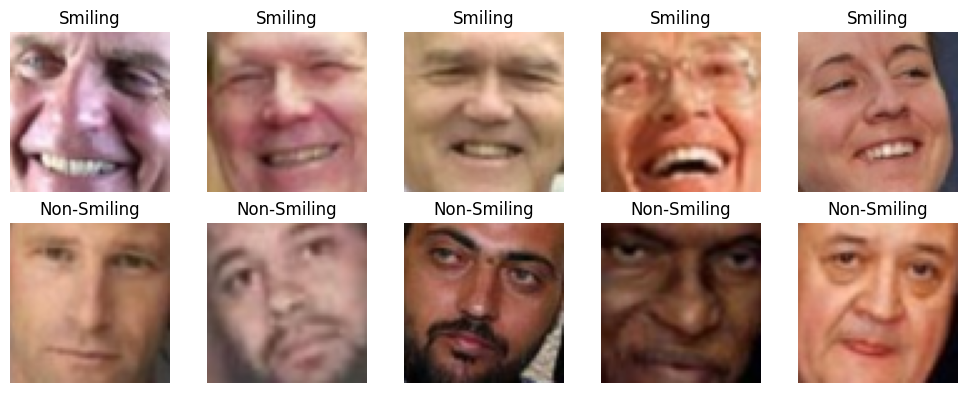

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

FACES_FOLDER   = r'C:\Users\Pedro\OneDrive\Proyecto 5to Semestre\5to Semestre\Incertidumbre\3er Periodo Neural Network\Proyecto\Smile-Detection-Model\lfwcrop_color\faces'
SMILE_FILE     = r'C:\Users\Pedro\OneDrive\Proyecto 5to Semestre\5to Semestre\Incertidumbre\3er Periodo Neural Network\Proyecto\Smile-Detection-Model\SMILE_list.txt'
NON_SMILE_FILE = r'C:\Users\Pedro\OneDrive\Proyecto 5to Semestre\5to Semestre\Incertidumbre\3er Periodo Neural Network\Proyecto\Smile-Detection-Model\NON-SMILE_list.txt'

lfw_dataset = LFWDataset(
    faces_folder=FACES_FOLDER,
    smiling_labels_file=SMILE_FILE,
    non_smiling_labels_file=NON_SMILE_FILE,
    transform=transform
)

test_size = int(0.15 * len(lfw_dataset))
train_val_size = len(lfw_dataset) - test_size

train_val_dataset, test_dataset = torch.utils.data.random_split(
    lfw_dataset,
    [train_val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

tv = TrainVal(lfw_dataset, val_split=0.15)

train_loader = DataLoader(tv.train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(tv.val_dataset,   batch_size=64, shuffle=False)

tv.visualize_samples()

In [8]:
def prepare_data(dataset):
    X_list = []
    y_list = []
    
    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]
        X_list.append(image.numpy().flatten())
        y_list.append(label)
    
    return np.array(X_list, dtype=np.float32), np.array(y_list)

X_train, y_train = prepare_data(tv.train_dataset)
X_val, y_val = prepare_data(tv.val_dataset)
X_test, y_test = prepare_data(test_dataset)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

n_parameters = sum(tree.tree_.node_count for tree in rf_model.estimators_)

y_train_pred = rf_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

y_val_pred = rf_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)

y_test_pred = rf_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("\nValidation Report:")
print(classification_report(y_val, y_val_pred, target_names=['Non-Smiling', 'Smiling']))

print("\nTest Report:")
print(classification_report(y_test, y_test_pred, target_names=['Non-Smiling', 'Smiling']))

sample_size = min(100, len(X_val))
X_sample = X_val[:sample_size]

times = []
for i in tqdm(range(100)):
    start = time.time()
    _ = rf_model.predict(X_sample)
    times.append((time.time() - start) / sample_size)

mean_time = np.mean(times)
std_time = np.std(times)

results = {
    'model': 'RandomForest',
    'train_accuracy': float(train_acc),
    'val_accuracy': float(val_acc),
    'test_accuracy': float(test_acc),
    'training_time_seconds': float(training_time),
    'inference_time_mean_ms': float(mean_time * 1000),
    'inference_time_std_ms': float(std_time * 1000),
    'n_parameters': int(n_parameters),
}

import json
with open('random_forest_results.json', 'w') as f:
    json.dump(results, f, indent=4)

joblib.dump(rf_model, 'random_forest_smile_model.pkl')

print(f"\nTrain Acc: {train_acc:.4f}")
print(f"Val Acc: {val_acc:.4f}")
print(f"Test Acc: {test_acc:.4f}")
print(f"Training Time: {training_time:.2f}s")
print(f"Inference: {mean_time*1000:.4f} ± {std_time*1000:.4f} ms")
print(f"Parameters: {n_parameters:,}")

100%|██████████| 180/180 [00:00<00:00, 3279.83it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished



Validation Report:
              precision    recall  f1-score   support

 Non-Smiling       0.82      0.92      0.87        90
     Smiling       0.91      0.80      0.85        90

    accuracy                           0.86       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.87      0.86      0.86       180


Test Report:
              precision    recall  f1-score   support

 Non-Smiling       0.82      0.92      0.87        90
     Smiling       0.91      0.80      0.85        90

    accuracy                           0.86       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.87      0.86      0.86       180



  0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12


Train Acc: 0.9824
Val Acc: 0.8611
Test Acc: 0.8611
Training Time: 0.43s
Inference: 0.1739 ± 0.0400 ms
Parameters: 6,766


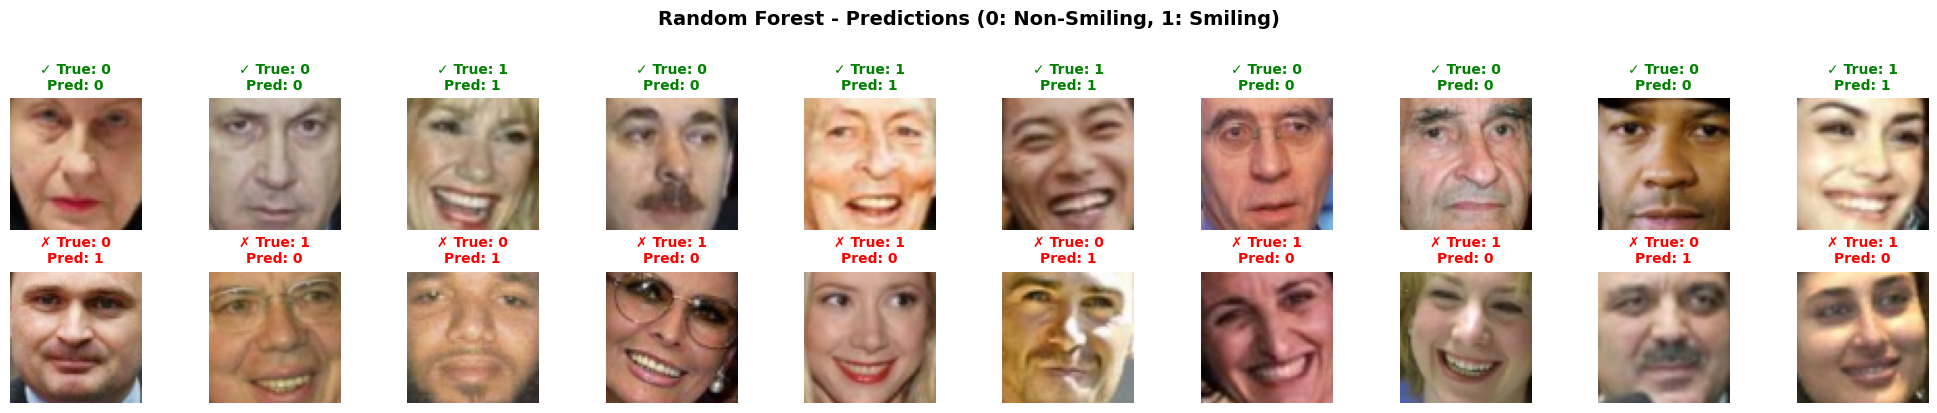

In [9]:
def visualize_predictions(dataset, predictions, n_samples=10):
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 4))
    
    correct_indices = [i for i in range(len(predictions)) if predictions[i] == dataset.dataset[dataset.indices[i]][1]]
    incorrect_indices = [i for i in range(len(predictions)) if predictions[i] != dataset.dataset[dataset.indices[i]][1]]
    
    np.random.shuffle(correct_indices)
    np.random.shuffle(incorrect_indices)
    
    for i in range(min(n_samples, len(correct_indices))):
        idx = correct_indices[i]
        image, true_label = dataset[idx]
        pred_label = predictions[idx]
        
        axes[0, i].imshow(image.permute(1, 2, 0))
        axes[0, i].set_title(f'✓ True: {true_label}\nPred: {pred_label}', 
                            color='green', fontsize=10, fontweight='bold')
        axes[0, i].axis('off')
    
    for i in range(min(n_samples, len(incorrect_indices))):
        idx = incorrect_indices[i]
        image, true_label = dataset[idx]
        pred_label = predictions[idx]
        
        axes[1, i].imshow(image.permute(1, 2, 0))
        axes[1, i].set_title(f'✗ True: {true_label}\nPred: {pred_label}', 
                            color='red', fontsize=10, fontweight='bold')
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Correct', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Incorrect', fontsize=12, fontweight='bold')
    
    plt.suptitle('Random Forest - Predictions (0: Non-Smiling, 1: Smiling)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('rf_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(test_dataset, y_test_pred, n_samples=10)